<a href="https://colab.research.google.com/github/BambangSinaga/ai_lab/blob/main/indo_bert_sentiment_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Indonesian Sentiment Classification with IndoBERT
**Objective:** Build, fine‑tune, and evaluate a BERT‑based classifier on an Indonesian sentiment dataset.

## 1. Install dependencies
Run the cell below once (or skip if the libraries are already installed in your runtime).

In [ ]:
!pip install -q --upgrade 'transformers>=4.20.0'

In [ ]:
!pip install -q transformers datasets torch scikit-learn pandas seaborn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 2. Imports

In [ ]:
import transformers, torch, pandas as pd, numpy as np, random, matplotlib.pyplot as plt, seaborn as sns
print('transformers version:', transformers.__version__)

transformers version: 4.51.3


## 3. Load dataset

In [ ]:
url = 'https://raw.githubusercontent.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/master/dataset_komentar_instagram_cyberbullying.csv'
df = pd.read_csv(url)
df.head()

,Id,Sentiment,Instagram Comment Text
0,1,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,2,negative,Geblek lo tata...cowo bgt dibela2in balikan......
2,3,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,4,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,5,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."


## 4. Preprocess & split

In [ ]:
label2id = {l:i for i,l in enumerate(sorted(df['Sentiment'].unique()))}
id2label = {i:l for l,i in label2id.items()}
df['label'] = df['Sentiment'].map(label2id)
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
len(train_df), len(test_df)

(320, 80)

## 5. Dataset & tokenizer

In [ ]:
from transformers import AutoTokenizer
model_name = 'indobenchmark/indobert-base-p1'
tokenizer = AutoTokenizer.from_pretrained(model_name)

class CommentDS(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.texts = df['Instagram Comment Text'].tolist()
        self.labels = df['label'].tolist()
        self.tok = tokenizer; self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tok(self.texts[idx], truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')
        item = {k:v.squeeze(0) for k,v in enc.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
train_ds, test_ds = CommentDS(train_df, tokenizer), CommentDS(test_df, tokenizer)

## 6. Model & Trainer

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, IntervalStrategy
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label2id), id2label=id2label, label2id=label2id)

args = TrainingArguments(
    output_dir='indo_bert_sentiment_ckpt',
    eval_strategy=IntervalStrategy.EPOCH,
    save_strategy=IntervalStrategy.EPOCH,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
def metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    return {'accuracy':acc,'precision':prec,'recall':rec,'f1':f1}

trainer = Trainer(model, args, train_dataset=train_ds, eval_dataset=test_ds, compute_metrics=metrics)
# trainer.train()

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 5. Tokenization and Dataset

In [ ]:
model_name = 'indobenchmark/indobert-base-p1'
tokenizer = AutoTokenizer.from_pretrained(model_name)

class CommentDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.texts = df['Instagram Comment Text'].tolist()
        self.labels = df['label'].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tokenizer(self.texts[idx], truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')
        item = {k:v.squeeze(0) for k,v in enc.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_ds = CommentDataset(train_df, tokenizer)
test_ds = CommentDataset(test_df, tokenizer)

## 6. Load model

In [ ]:
num_labels = len(label2id)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, id2label=id2label, label2id=label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 7. Training

In [ ]:
args = TrainingArguments('indo_bert_sentiment_ckpt',
                        eval_strategy='epoch',
                        save_strategy='epoch',
                        learning_rate=2e-5,
                        per_device_train_batch_size=16,
                        per_device_eval_batch_size=16,
                        num_train_epochs=3,
                        weight_decay=0.01,
                        load_best_model_at_end=True,
                        metric_for_best_model='accuracy')

def metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    return {'accuracy':acc,'precision':prec,'recall':rec,'f1':f1}

trainer = Trainer(model=model, args=args, train_dataset=train_ds, eval_dataset=test_ds, compute_metrics=metrics)
# trainer.train()

## 8. Evaluation

In [ ]:
# If you skipped training, load a fine‑tuned checkpoint instead.
eval_results = trainer.evaluate()
eval_results

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mejbambang (mejbambang-binus-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'eval_loss': 0.7014870643615723,
 'eval_model_preparation_time': 0.004,
 'eval_accuracy': 0.5,
 'eval_precision': 0.5,
 'eval_recall': 0.5,
 'eval_f1': 0.4791666666666667,
 'eval_runtime': 39.6619,
 'eval_samples_per_second': 2.017,
 'eval_steps_per_second': 0.126}

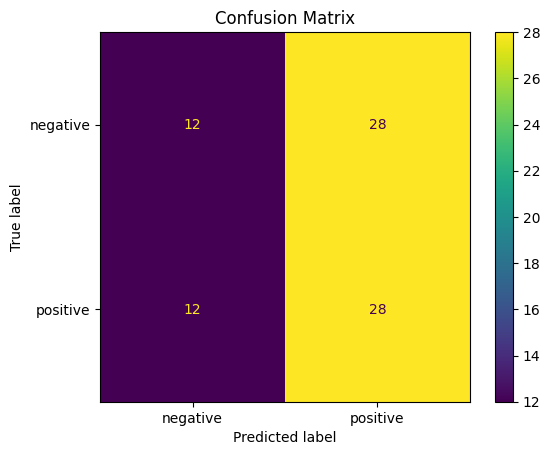

In [ ]:
preds = np.argmax(trainer.predict(test_ds).predictions, axis=-1)
cm = confusion_matrix(test_df['label'], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label2id.keys())
disp.plot(values_format='d')
plt.title('Confusion Matrix')
plt.show()

## 9. Error analysis

In [ ]:
errors = test_df.copy()
errors['pred'] = preds
errors = errors[errors['label'] != errors['pred']]
errors.head()

,Id,Sentiment,Instagram Comment Text,label,pred
192,193,negative,Editanx paraaaahh...oplas aj laaah nyai drpd n...,0,1
52,53,negative,Biasalah kalo pelakor banyak yang lbh ancur mu...,0,1
50,51,negative,Alah laki laki jaman skrg sm aja. Sama sama be...,0,1
196,197,negative,"wey org goblok juga bisa bedain vape, shisha s...",0,1
382,383,positive,Pernah ketemu sama mba artika sari disesemall ...,1,0


### 9.1 Discussion
- **Common errors:** Observe the misclassified samples above and note patterns (e.g. sarcasm, mixed language, emojis).
- **Language‑specific challenges:** Indonesian informal spelling, slang, or code‑switching can confuse the model; consider additional preprocessing or larger models.
- **Next steps:** Data cleaning, emoji translation, or experimenting with larger IndoBERTweet models.

---
© 2025 ‑ Prepared for educational use.